# Analysis & visualization of results

In [1]:
import pandas as pd
import seaborn as sns

In [3]:
# need `pyarrow` package to load parquet files
df = pd.read_csv('results_clust_v2.csv')
df.head()


EmptyDataError: No columns to parse from file

In [ ]:
# check: for an iter, how many clusters are there?
df[df['fit_train']==True].groupby('iter')['cluster_nr'].nunique().value_counts()

cluster_nr
10    75
11    25
Name: count, dtype: int64

Below, we read in the results from applying HBAC on random noise data (from a standard normal distribution) and then computing the difference between each cluster and the other clusters.

In total, the analysis was repeated 500 times ('iterations'):

In [ ]:
df['iter'].min(), df['iter'].max()

(0, 99)

To get insight into what factors mitigate or exacerbate the potential 'bias' in the method, I varied a couple of parameters in the experiment, such as the number of observations (`N`):

In [ ]:
df['N_k'].unique()

array([100])

... and the number of features (`d`):

In [ ]:
df['d'].unique()

array([10])

And importantly I ran the experiment for different target variables (`target_col`):

In [ ]:
df['target_col']

0          y
1          y
2          y
3          y
4          y
        ... 
11481    err
11482    err
11483    err
11484    err
11485    err
Name: target_col, Length: 11486, dtype: object

In technical terms, using `y_pred` boils down to _demographic parity_, `fp` to _predictive equality_, etc. etc. Importantly, I also added the complement of _precision_ (`fp_prec`) and _recall_ (`fn_rec`), as this doesn't group true positives and false negatives together (as `fp` does).

Also, separate experiments are run with and without bonferroni correction to correct for the testing of multiple clusters (`bonf_correct`). To compare HBAC to truly random clusters, the experiment was also run on data where each observation was assigned one of five random cluster labels (literally just `np.random.choice(range(5), size=N)`):

In [ ]:
df['method'].unique()

array(['hbac', 'randomclusters'], dtype=object)

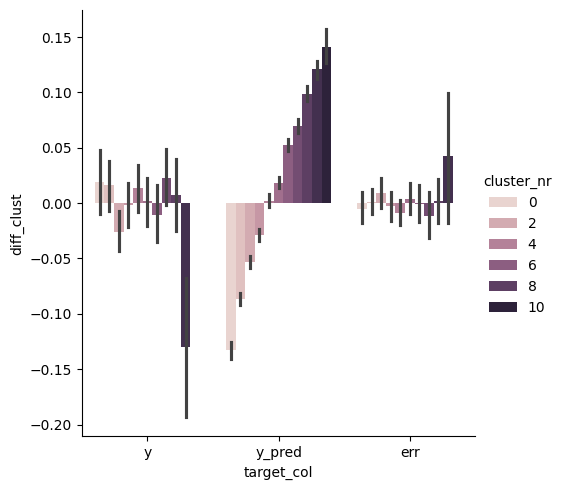

In [ ]:

# select it for a specific K, N
K = 10
N = 1000
df_selected = df[(df['K'] == K) & (df['N'] == N)]

# select the df with specific train_fit
df_fit = df[df['fit_train'] == True]

# select the df with hbac method
df_fit_hbac = df_fit[df_fit['method'] == 'hbac']


# create plot
g = sns.catplot(df_fit_hbac, x='target_col', y='diff_clust', hue='cluster_nr', kind='bar')

* Difference remains for y_pred, fp, fn, not for err

In [ ]:
df_bonf = df.query("method == 'hbac'").copy()
df_bonf['sig_clust'] = ((df_bonf['p_clust'] < 0.05) & (df_bonf['diff_clust'] > 0)).astype(int)
params = ['iter', 'N', 'K', 'target_col', 'method', 'bonf_correct']
df_av = df_bonf.groupby(params).mean().reset_index()
df_av['at_least_one'] = (df_av['sig_clust'] > 0).astype(int)

# only show for selected K, N
df_av = df_av[(df_av['K'] == K) & (df_av['N'] == N)]
g = sns.catplot(data=df_av, x='target_col', y='at_least_one', hue='bonf_correct', kind='bar')
g.ax.axhline(0.05, ls='--', c='k')
g.ax.set_ylabel("False positive rate")

TypeError: agg function failed [how->mean,dtype->object]

For several metrics (like `fn`, `fp`, `y_pred`), the FPR is as high as 0.5, meaning that in 50% of the times HBAC is applied to random data, it will find at least one significant cluster. Just for good measure, when clusters are truly randomly generated, the expected FPR is actually approximately 0.05 (after bonferroni correction):

Text(42.15678698881173, 0.5, 'False positive rate')

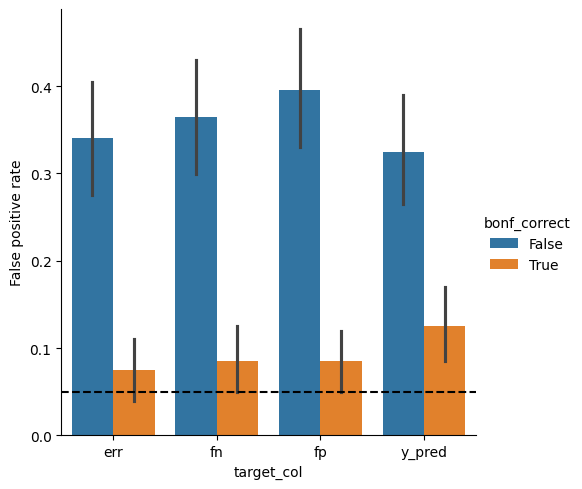

In [ ]:
df_bonf = df.query("method == 'randomclusters'").copy()
df_bonf['sig_clust'] = (df_bonf['p_clust'] < 0.05).astype(int)
params = ['iter', 'N', 'K', 'target_col', 'method', 'bonf_correct']
df_bonf = df_bonf.groupby(params).mean().reset_index()
df_bonf['at_least_one'] = (df_bonf['sig_clust'] > 0).astype(int)

# only show for selected K, N
df_av = df_bonf[(df_bonf['K'] == K) & (df_bonf['N'] == N)]
g = sns.catplot(data=df_bonf, x='target_col', y='at_least_one', hue='bonf_correct', kind='bar')
g.ax.axhline(0.05, ls='--', c='k')
g.ax.set_ylabel('False positive rate')

As hinted at before when plotting the average differences per cluster, the largest differences and thus the largest proportion of significant results occur in the 'higher' cluster numbers:

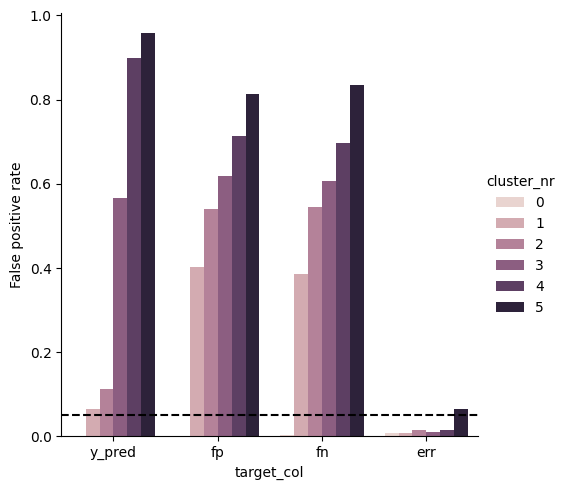

In [ ]:
# To be lenient, let's only consider differences > 0 (not < 0)
df_['sig_clust'] = ((df_['p_clust'] < 0.05) & (df_['diff_clust'] > 0)).astype(int)
g = sns.catplot(data=df_, x='target_col', y='sig_clust', hue='cluster_nr', kind='bar', errorbar=None)
g.ax.axhline(0.05, ls='--', c='k')
g.ax.set_ylabel('False positive rate');

This kind of makes sense, as the method only allows to split into new clusters as the new clusters show bigger 'bias' than the original cluster (the line `max(score0, score1) >= score` in HBAC).